In [1]:
import numpy as np
def data_generate(num, dim, dist = 2.0, sigma = 1.0):
    x = np.zeros(shape = (num, dim,))
    y = np.zeros(shape = (num,))
    rand = np.random.rand(num)
    inds = rand < 0.2
    theta = np.zeros(shape = (dim,))
    theta[0] = -dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = 1
    inds = np.logical_and(rand >= 0.2, rand < 0.5)
    theta = np.zeros(shape = (dim,))
    theta[0] = dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = 1
    inds = np.logical_and(rand >= 0.5, rand < 0.9)
    theta = np.zeros(shape = (dim,))
    theta[1] = -dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = -1
    inds = rand >= 0.9
    theta = np.zeros(shape = (dim,))
    theta[1] = dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = -1
    return x, y
    

In [2]:
import cvxpy as cp
def erm_hinge(x, y):
    dim = x.shape[1]
    theta = cp.Variable(dim)
    intercept = cp.Variable()
    hinge = cp.sum(cp.pos(np.ones_like(y) - cp.multiply(y, cp.matmul(x, theta) + intercept * np.ones_like(y))))
    obj = cp.Minimize(hinge)
    prob = cp.Problem(obj,)
    prob.solve(solver = cp.GUROBI)
    return theta.value, intercept.value

In [3]:
import cvxpy as cp
def grad_hinge(x, y, theta, intercept):
    num = x.shape[0]
    dim = x.shape[1]
    grad = np.zeros(shape = (num, theta.shape[0] + 1,))
    inds = np.multiply(y, np.matmul(x, theta) + intercept) < 1.0
    grad[inds, :dim] = -np.einsum('i,ij->ij', y[inds], x[inds, :])
    grad[inds, dim:] = -np.reshape(y[inds], (-1, 1))
    return grad

def uncert(x, theta, intercept, mu = 1.0):
    return np.divide(1.0, 1.0 + mu * np.absolute(np.matmul(x, theta) + intercept))

def grad_equiv(x, y, theta, intercept, mu = 1.0):
    return np.average(np.einsum('i,ij->ij', uncert(x, theta, intercept, mu), grad_hinge(x, y, theta, intercept)), axis = 0)

def erm_equiv(x, y, mu = 1.0, tol = 1e-10, max_iter = 1e5, step_size = 1e-2, is_print = False, init = None):
    dim = x.shape[1]
    if init is None:
    # Random initialization
        theta = np.random.normal(size = dim)
        intercept = np.random.normal(size = (1,))
    else:
        theta = init[:dim]
        intercept = init[dim:]
    grad = grad_equiv(x, y, theta, intercept, mu)
    count = 0
    while np.linalg.norm(grad) > tol:
        theta -= grad[:dim] * step_size
        intercept -= grad[dim:] * step_size
        grad = grad_equiv(x, y, theta, intercept, mu)
        count += 1
        if is_print and count % 1000 == 0:
            print(count, np.linalg.norm(grad))
        if count > max_iter:
            print("max_iter")
            break
    return theta, intercept[0]

In [4]:
x, y = data_generate(num = 10000, dim = 2, dist = 2.0, sigma = 0.5)

In [6]:
theta_hinge, inter_hinge = erm_hinge(x, y)

In [7]:
init = np.array([0.05333351, 1.61913619, 1.6384193453197093])
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=2e-3, is_print = True, max_iter = 1e5, mu = 10.0, init = init)

1000 0.0025687313969661616
2000 0.0022350443468732236
3000 0.0020619536432561676
4000 0.0019496187129998395
5000 0.001889162954768194
6000 0.001842113292868522
7000 0.0018170876362554528
8000 0.0017981213609103651
9000 0.0017807699699805349
10000 0.0017497063637271237
11000 0.001729146837233021
12000 0.0017034914622047052
13000 0.0016939738362448096
14000 0.0016748177692851275
15000 0.0016576127952947907
16000 0.0016407961063812345
17000 0.0016123333620545696
18000 0.0015979738431297582
19000 0.0015885706135602689
20000 0.001572988525008643
21000 0.0015574070718903897
22000 0.001535562448893546
23000 0.0015308850771030267
24000 0.001507051519262673
25000 0.001487449705231327
26000 0.0014792353764481066
27000 0.0014665413769761795
28000 0.0014422816719599492
29000 0.0014264913512585199
30000 0.0014180411692813635
31000 0.0014019794371449737
32000 0.0013857424141522055
33000 0.0013739069961264988
34000 0.001362262506131956
35000 0.0013467825868123202
36000 0.0013250029309241935
37000 0.0

In [8]:
theta_eq1_1 = np.copy(theta_eq1)
inter_eq1_1 = np.copy(inter_eq1)

In [9]:
init = np.array([0.05333351, -1.61913619, 1.6384193453197093])
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=2e-3, is_print = True, max_iter = 1e5, mu = 10.0, init = init)

1000 0.02625815558520679
2000 0.023393097715110642
3000 0.021207966245431618
4000 0.01937048043084086
5000 0.01772417968833783
6000 0.01644697767489001
7000 0.01576803798333393
8000 0.015352906826230008
9000 0.015045337392239502
10000 0.014824874430344503
11000 0.014585674684031226
12000 0.014485108700840106
13000 0.014371686949347366
14000 0.014369466449986873
15000 0.01433321837798807
16000 0.014338033750437353
17000 0.014338449644687362
18000 0.014338346663433244
19000 0.014305188539478118
20000 0.014310779834667177
21000 0.014242030685848795
22000 0.014166949408315036
23000 0.014074810012763294
24000 0.014072391614212297
25000 0.01406904174717437
26000 0.01391076088966878
27000 0.013838653337535901
28000 0.013671214752850639
29000 0.013426518302573354
30000 0.0132189301908602
31000 0.012973030981368852
32000 0.012775472182643802
33000 0.012542780512040264
34000 0.012197836311040842
35000 0.011891074168569375
36000 0.01143443306781597
37000 0.011103991817963364
38000 0.0106792834627

In [10]:
theta_eq1_2 = np.copy(theta_eq1)
inter_eq1_2 = np.copy(inter_eq1)

In [11]:
init = np.array([-1.61913619, 0.05333351, -1.6384193453197093])
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=2e-3, is_print = True, max_iter = 1e5, mu = 10.0, init = init)

1000 0.016733442877528336
2000 0.01365000278557567
3000 0.01166372687741867
4000 0.01025076246418873
5000 0.009559061952033415
6000 0.009240805338865735
7000 0.00901985644136195
8000 0.008885718458151153
9000 0.008800504383000975
10000 0.008733955034974318
11000 0.008702323930330417
12000 0.008673464063790232
13000 0.008642707367113442
14000 0.00858553509651662
15000 0.008554738497891352
16000 0.00848303417621638
17000 0.00845757128901267
18000 0.008425099626617982
19000 0.008404769362034678
20000 0.00839237451289537
21000 0.008347737996764623
22000 0.008225574107843749
23000 0.008199341823035085
24000 0.008135232639607045
25000 0.008098419725893811
26000 0.00804146943356027
27000 0.007968322713965524
28000 0.007900514599801184
29000 0.007830577017780432
30000 0.007732628460694051
31000 0.0076774019680687575
32000 0.007536665297559564
33000 0.007458166332235361
34000 0.007272514681122123
35000 0.007167171856734095
36000 0.007100227782103614
37000 0.0070232225936771
38000 0.006899335062

In [12]:
theta_eq1_3 = np.copy(theta_eq1)
inter_eq1_3 = np.copy(inter_eq1)

In [13]:
init = np.array([1.61913619, 0.05333351, -1.6384193453197093])
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=2e-3, is_print = True, max_iter = 1e5, mu = 10.0, init = init)

1000 0.013302353337941483
2000 0.010432000558405359
3000 0.00832604487540693
4000 0.006385183082089138
5000 0.005404974446058026
6000 0.00490972640120295
7000 0.004588320156587156
8000 0.00441687187043779
9000 0.00429427899059696
10000 0.004191923764566018
11000 0.004156448822697337
12000 0.004132619154840859
13000 0.004110805508694417
14000 0.004063359341189416
15000 0.004017613398549257
16000 0.0039805169330833804
17000 0.003952569493170652
18000 0.003939089215605109
19000 0.003929210672334036
20000 0.0038929557264836758
21000 0.0038739761488317988
22000 0.003839932058597933
23000 0.0038163528334687023
24000 0.0037966589708771587
25000 0.003778748108877043
26000 0.0037822067250414294
27000 0.0037364902522190185
28000 0.0036862753015982942
29000 0.003649321527499638
30000 0.003642333418008702
31000 0.003618122106377198
32000 0.0035689566875783613
33000 0.003502648901834788
34000 0.0034814755142005076
35000 0.0034604601450706003
36000 0.0034176878161454654
37000 0.003397235202747866
38

In [14]:
theta_eq1_4 = np.copy(theta_eq1)
inter_eq1_4 = np.copy(inter_eq1)

In [15]:
from tqdm import tqdm
def uncertain_sampling(x, y, mu = 1.0, max_iter = 1e6, step_size = 1e-3, init = None):
    num = x.shape[0]
    dim = x.shape[1]
    if init is None:
        # Random initialization
        theta = np.random.normal(size = dim)
        intercept = np.random.normal(size = (1,))
    else:
        theta = init[:dim]
        intercept = init[dim:]
    for count in tqdm(range(int(max_iter))):
        sample = np.random.randint(low=0, high=num)
        U = uncert(x[sample], theta, intercept, mu)
        tmp = np.random.rand()
        if tmp <= U:
            grad = grad_hinge(np.reshape(x[sample], (1, -1)), np.atleast_1d(y[sample]), theta, intercept).flatten()
            theta -= grad[:dim] * step_size
            intercept -= grad[dim:] * step_size
    return theta, intercept[0]

In [16]:
init = np.array([0.05333351, 1.61913619, 1.6384193453197093])
theta_us1, inter_us1 = uncertain_sampling(x, y, mu = 10.0, max_iter = 1e7, step_size = 1e-4, init = init)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [01:46<00:00, 94103.92it/s]


In [17]:
theta_us1_1 = np.copy(theta_us1)
inter_us1_1 = np.copy(inter_us1)

In [18]:
init = np.array([0.05333351, -1.61913619, 1.6384193453197093])
theta_us1, inter_us1 = uncertain_sampling(x, y, mu = 10.0, max_iter = 1e7, step_size = 1e-4, init = init)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [01:59<00:00, 83581.39it/s]


In [19]:
theta_us1_2 = np.copy(theta_us1)
inter_us1_2 = np.copy(inter_us1)

In [20]:
init = np.array([-1.61913619, 0.05333351, -1.6384193453197093])
theta_us1, inter_us1 = uncertain_sampling(x, y, mu = 10.0, max_iter = 1e7, step_size = 1e-4, init = init)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [01:54<00:00, 87604.94it/s]


In [21]:
theta_us1_3 = np.copy(theta_us1)
inter_us1_3 = np.copy(inter_us1)

In [22]:
init = np.array([1.61913619, 0.05333351, -1.6384193453197093])
theta_us1, inter_us1 = uncertain_sampling(x, y, mu = 10.0, max_iter = 1e7, step_size = 1e-4, init = init)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [01:50<00:00, 90263.62it/s]


In [23]:
theta_us1_4 = np.copy(theta_us1)
inter_us1_4 = np.copy(inter_us1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


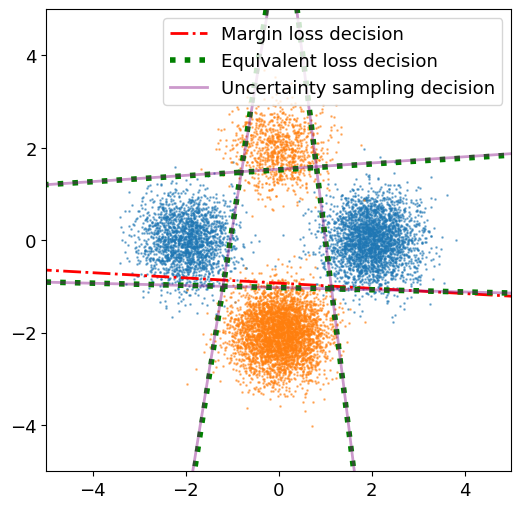

In [24]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(6, 6))
inds = y == 1
# plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.6, alpha = 0.5, label = 'positive')
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
# plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.6, alpha = 0.5, label = 'negative')
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_hinge = (-inter_hinge - theta_hinge[1] * vert_grid) / theta_hinge[0]
plt.plot(hori_hinge, vert_grid, linestyle = 'dashdot', label = 'Margin loss decision', color = 'red', alpha = 1.0, linewidth = 2.0)
hori_eq1_1 = (-inter_eq1_1 - theta_eq1_1[1] * vert_grid) / theta_eq1_1[0]
plt.plot(hori_eq1_1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 4.0)
hori_eq1_2 = (-inter_eq1_2 - theta_eq1_2[1] * vert_grid) / theta_eq1_2[0]
plt.plot(hori_eq1_2, vert_grid, linestyle = 'dotted', color = 'green', alpha = 1.0, linewidth = 4.0)
hori_eq1_3 = (-inter_eq1_3 - theta_eq1_3[1] * vert_grid) / theta_eq1_3[0]
plt.plot(hori_eq1_3, vert_grid, linestyle = 'dotted', color = 'green', alpha = 1.0, linewidth = 4.0)
hori_eq1_4 = (-inter_eq1_4 - theta_eq1_4[1] * vert_grid) / theta_eq1_4[0]
plt.plot(hori_eq1_4, vert_grid, linestyle = 'dotted', color = 'green', alpha = 1.0, linewidth = 4.0)
hori_us1_1 = (-inter_us1_1 - theta_us1_1[1] * vert_grid) / theta_us1_1[0]
plt.plot(hori_us1_1, vert_grid, linestyle = 'solid', label = r'Uncertainty sampling decision', color = 'purple', alpha = 0.4, linewidth = 2.0)
hori_us1_2 = (-inter_us1_2 - theta_us1_2[1] * vert_grid) / theta_us1_2[0]
plt.plot(hori_us1_2, vert_grid, linestyle = 'solid', color = 'purple', alpha = 0.4, linewidth = 2.0)
hori_us1_3 = (-inter_us1_3 - theta_us1_3[1] * vert_grid) / theta_us1_3[0]
plt.plot(hori_us1_3, vert_grid, linestyle = 'solid', color = 'purple', alpha = 0.4, linewidth = 2.0)
hori_us1_4 = (-inter_us1_4 - theta_us1_4[1] * vert_grid) / theta_us1_4[0]
plt.plot(hori_us1_4, vert_grid, linestyle = 'solid', color = 'purple', alpha = 0.4, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.savefig("Experiment1-4.eps", bbox_inches='tight')
plt.savefig("Experiment1-4.jpg", bbox_inches='tight')
plt.show()